In [88]:
import numpy as np
import pandas as pd
import seaborn as sns
import importlib
import geopandas
import os

import matplotlib.pyplot as plt
import plotly.graph_objects as go

from datetime import datetime
from shapely.geometry import Point

from libdata import wrangle
from libdata import func

In [102]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 8]

In [2]:
%load_ext autoreload
%autoreload 3

# Read data

In [3]:
city_temp_file = os.path.join(
    os.environ['HOME'], 
    'data',
    'global-temperature',
    'GlobalLandTemperaturesByCity.csv')
global_temp_file = os.path.join(
    os.environ['HOME'], 
    'data',
    'global-temperature',
    'GlobalTemperatures.csv')

In [4]:
city_temp = pd.read_csv(city_temp_file)
global_temp = pd.read_csv(global_temp_file)

In [5]:
city_temp[:5]

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
0,1743-11-01,6.068,1.737,Århus,Denmark,57.05N,10.33E
1,1743-12-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
2,1744-01-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
3,1744-02-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
4,1744-03-01,NaN,NaN,Århus,Denmark,57.05N,10.33E


In [6]:
global_temp[:5]

,dt,LandAverageTemperature,LandAverageTemperatureUncertainty,LandMaxTemperature,LandMaxTemperatureUncertainty,LandMinTemperature,LandMinTemperatureUncertainty,LandAndOceanAverageTemperature,LandAndOceanAverageTemperatureUncertainty
0,1750-01-01,3.034,3.574,NaN,NaN,NaN,NaN,NaN,NaN
1,1750-02-01,3.083,3.702,NaN,NaN,NaN,NaN,NaN,NaN
2,1750-03-01,5.626,3.076,NaN,NaN,NaN,NaN,NaN,NaN
3,1750-04-01,8.490,2.451,NaN,NaN,NaN,NaN,NaN,NaN
4,1750-05-01,11.573,2.072,NaN,NaN,NaN,NaN,NaN,NaN


# Explore distributions

## Global temperature (by month)

In [7]:
global_temp = wrangle.split_month_year(global_temp)

In [8]:
global_temp.columns

Index(['dt', 'LandAverageTemperature', 'LandAverageTemperatureUncertainty',
       'LandMaxTemperature', 'LandMaxTemperatureUncertainty',
       'LandMinTemperature', 'LandMinTemperatureUncertainty',
       'LandAndOceanAverageTemperature',
       'LandAndOceanAverageTemperatureUncertainty', 'year', 'month'],
      dtype='object')

In [9]:
(min(global_temp.year), max(global_temp.year))

(1750, 2015)

In [27]:
# Aggregate by year for plotting
monthly_global_temp = global_temp.groupby(['year','month']).agg({
    'LandAverageTemperature': ['min']
})
monthly_global_temp.reset_index(inplace=True)
monthly_global_temp.columns = ['year','month','AverageTemperature']
monthly_global_temp[-5:]

,year,month,AverageTemperature
3187,2015,8,14.755
3188,2015,9,12.999
3189,2015,10,10.801
3190,2015,11,7.433
3191,2015,12,5.518


Min/Max temperatures of each year

In [64]:
bound_global_temp = global_temp.groupby('year').agg({
    'LandAverageTemperature': ['min','max']
}).reset_index(drop=False)
bound_global_temp[:5]

year LandAverageTemperature        
                           min     max
0  1750                  2.772  15.868
1  1751                  0.963  14.405
2  1752                  0.348   8.265
3  1753                  0.559  15.092
4  1754                 -1.249  14.681

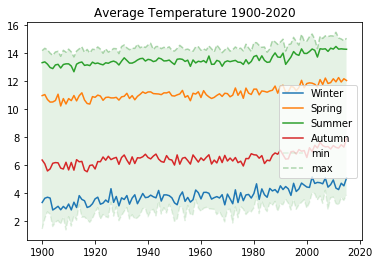

In [72]:
fig = plt.figure()
# split into 4 quaters of the year 
# and plot comparison

mgt = monthly_global_temp[monthly_global_temp['year'] >= 1900]
bound = bound_global_temp[bound_global_temp['year'] >= 1900]

q = [1,4,7,10,13]
t = mgt['year'].drop_duplicates(keep='first')
Q = {1: 'Winter', 4: 'Spring', 7: 'Summer', 10: 'Autumn'}

for lower, upper in [(a,b-1) for a,b in zip(q,q[1:])]:
    y = mgt[(mgt['month'] >= lower) & (mgt['month'] <= upper)]
    y = y.groupby('year').agg({'AverageTemperature':'mean'})
    plt.plot(t, y['AverageTemperature'], label=Q[lower])
    
plt.plot(t, bound['LandAverageTemperature']['min'], 'g--', label='min', alpha=0.1)
plt.plot(t, bound['LandAverageTemperature']['max'], 'g--', label='max', alpha=0.3)
plt.fill_between(
    t, 
    bound['LandAverageTemperature']['min'], 
    bound['LandAverageTemperature']['max'],
    facecolor='green', alpha=0.1)

plt.title('Average Temperature 1900-2020')
plt.legend()
plt.show()

In [79]:
temp = monthly_global_temp[monthly_global_temp['year']>=1940]

tt = temp.groupby('year').agg({'AverageTemperature': ['min','max','mean']}).reset_index(drop=False)

fig = go.Figure(data=[
    go.Candlestick(x=tt['year'],
    open=tt['AverageTemperature']['mean'],
    close=tt['AverageTemperature']['mean'],
    high=tt['AverageTemperature']['max'],
    low=tt['AverageTemperature']['min'])
])

fig.update_layout(
    title='Annual Global Temperature 1940-2020',
    yaxis_title='°C',
    xaxis_title='year',
    
)
fig.show()

## Temperature by city

In [12]:
city_temp = wrangle.split_month_year(city_temp)

In [13]:
city_temp.columns

Index(['dt', 'AverageTemperature', 'AverageTemperatureUncertainty', 'City',
       'Country', 'Latitude', 'Longitude', 'year', 'month'],
      dtype='object')

In [14]:
len(set(city_temp.City))

3448

In [15]:
#importlib.reload(func)
#importlib.reload(wrangle)

In [16]:
latest_city_temp = wrangle.take_last_year(city_temp)
latest_city_temp[:3]

,AverageTemperature,month,City,Country,Latitude,Longitude
3230,-0.344,1,Århus,Denmark,57.05N,10.33E
3231,-0.390,2,Århus,Denmark,57.05N,10.33E
3232,-0.474,3,Århus,Denmark,57.05N,10.33E


In [17]:
map_city_latlng = wrangle.create_city_latlng_map(latest_city_temp)
map_city_latlng

{'0.80N-103.66E': ('Johor Bahru', 'Malaysia'),
 '0.80N-108.48E': ('Singkawang', 'Indonesia'),
 '0.80N-110.09E': ('Kuching', 'Malaysia'),
 '0.80N-118.13E': ('Bontang', 'Indonesia'),
 '0.80N-122.95E': ('Gorontalo', 'Indonesia'),
 '0.80N-124.55E': ('Bitung', 'Indonesia'),
 '0.80N-127.77E': ('Ternate', 'Indonesia'),
 '0.80N-18.48E': ('Mbandaka', 'Congo (Democratic Republic Of The)'),
 '0.80N-24.91E': ('Kisangani', 'Congo (Democratic Republic Of The)'),
 '0.80N-29.73E': ('Butembo', 'Congo (Democratic Republic Of The)'),
 '0.80N-32.95E': ('Kampala', 'Uganda'),
 '0.80N-34.55E': ('Eldoret', 'Kenya'),
 '0.80N-42.59E': ('Jamame', 'Somalia'),
 '0.80N-50.63W': ('Macapá', 'Brazil'),
 '0.80N-77.95W': ('Ibarra', 'Ecuador'),
 '0.80N-8.84E': ('Libreville', 'Gabon'),
 '0.80S-100.45E': ('Padang', 'Indonesia'),
 '0.80S-103.66E': ('Jambi', 'Indonesia'),
 '0.80S-110.09E': ('Pontianak', 'Indonesia'),
 '0.80S-116.52E': ('Balikpapan', 'Indonesia'),
 '0.80S-119.73E': ('Palu', 'Indonesia'),
 '0.80S-130.98E': ('S

In [18]:
len(map_city_latlng)

1366

In [97]:
climate = wrangle.agg_monthly_climate(latest_city_temp)
climate[:5]

Latitude Longitude AverageTemperature          \
                                    min     max   
0    0.80N   103.66E             26.563  28.662   
1    0.80N   108.48E             27.127  29.231   
2    0.80N   110.09E             26.472  27.875   
3    0.80N   118.13E             26.814  28.220   
4    0.80N   122.95E             26.076  27.460   

                                                      
                                             collect  
0  [26.836, 26.563000000000002, 28.053, 27.767000...  
1  [27.275, 27.127, 28.277, 28.217, 28.483, 29.23...  
2  [26.684, 26.472, 27.38600000000001, 27.0269999...  
3  [27.096, 26.814, 27.932, 27.745, 27.795, 28.22...  
4  [26.442, 26.54, 27.46, 27.042, 27.088, 27.087,...

In [98]:
# Flatten multilevel index columns
def last_opt(cols):
    # Single-level column has empty subcolumns, so ignore the empty ones
    return [c for c in cols if len(c.strip())>0][-1]
    
climate.columns = [last_opt(cols) for cols in climate.columns.values]
climate[:5]

,Latitude,Longitude,min,max,collect
0,0.80N,103.66E,26.563,28.662,"[26.836, 26.563000000000002, 28.053, 27.767000..."
1,0.80N,108.48E,27.127,29.231,"[27.275, 27.127, 28.277, 28.217, 28.483, 29.23..."
2,0.80N,110.09E,26.472,27.875,"[26.684, 26.472, 27.38600000000001, 27.0269999..."
3,0.80N,118.13E,26.814,28.220,"[27.096, 26.814, 27.932, 27.745, 27.795, 28.22..."
4,0.80N,122.95E,26.076,27.460,"[26.442, 26.54, 27.46, 27.042, 27.088, 27.087,..."


Plot distribution of latitudes, longitudes

In [104]:
clipstr = lambda s: float(s[:-1])

coords = [Point((clipstr(b), clipstr(a))) for (a,b) in zip(climate['Latitude'], climate['Longitude'])]
gf = geopandas.GeoDataFrame(climate, geometry=coords)

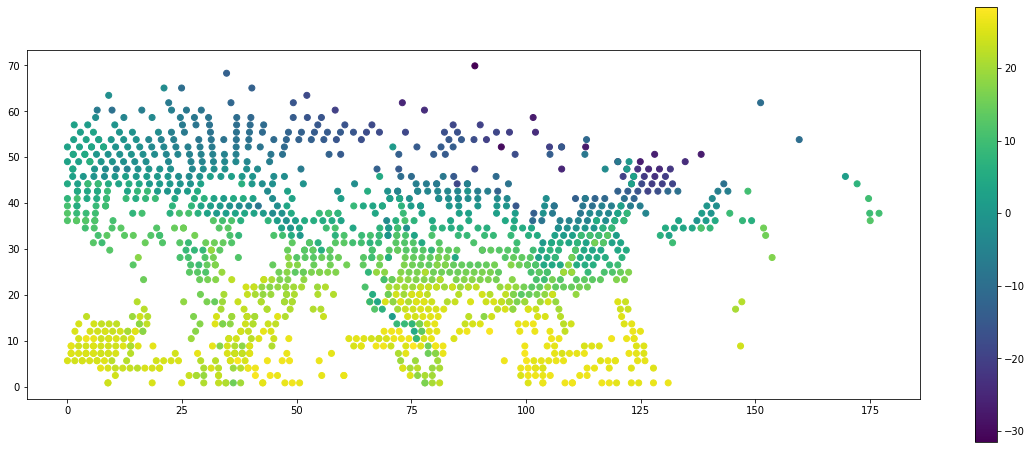

In [105]:
gf.plot(column="min", legend=True)

# TODOs
- Strata sampling
- Re-explore distributions after sampling
- Fill N/As